1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [1]:
import pandas as pd
import numpy as np
from scipy import linalg as la

N=1000
x1 = np.random.normal(0,1, size=N)
x2 = x1 + np.random.normal(0,3,size=N)
x3 = 2*x1 + x2

data = np.array([x1,x2,x3])
df = pd.DataFrame([x1,x2,x3])
print(df)

sigma = np.cov(data) 
l,V = la.eig(sigma)
print(f'The eigenvalues are: {l} \nThe corresponding eigenvector are: \n{V.T}')
print('The real part of the complex eigenvalues:\n', np.real_if_close(l))


        0         1         2         3         4         5         6    \
0  0.068151 -1.143296 -0.465203  0.966375  1.218541  0.035744 -0.527157   
1 -1.380941 -1.266262 -6.389846  3.887550  0.481752  2.409451  1.238650   
2 -1.244638 -3.552854 -7.320252  5.820301  2.918833  2.480939  0.184337   

        7         8         9    ...       990       991       992       993  \
0  0.627718  1.527757  0.025812  ... -0.070214  0.241354  0.986530 -0.411268   
1 -5.606060 -0.265240 -2.426201  ...  1.436788  1.732960 -1.820664  4.726842   
2 -4.350625  2.790275 -2.374578  ...  1.296361  2.215668  0.152396  3.904305   

        994       995       996       997       998       999  
0 -0.502741 -0.077536  0.331105 -1.258968  0.107027 -0.607194  
1 -1.171443 -4.803073 -0.062780 -0.740968 -7.111675  0.538308  
2 -2.176924 -4.958145  0.599430 -3.258904 -6.897621 -0.676079  

[3 rows x 1000 columns]
The eigenvalues are: [ 2.60549670e+01+0.j -2.00079050e-15+0.j  1.94430523e+00+0.j] 
The correspon

In [2]:
U, spect, Vt = la.svd(df)
print(U)
print(f'Spectrum {spect}')

#checking the results
print('Eigenvlues')
print(np.sort(np.real_if_close(l)))
print('with SVD\n',spect)
# print('with SVD\n',np.sort(spect**2/(N-1)))

print('Eigenvectures')
print(V)
print('with SVD\n', U)

# spect = np.sort(spect**2/(N-1))
#check
# I = np.identity(3)
# res_SVD = [la.det((sigma - i*I)) for i in spect]
# res = [la.det((sigma - i*I)) for i in np.real_if_close(l)]
# print('result with svd',res_SVD)
# print(res)
'''Sembra che la seconda procedura sia più prescisa in termini di calcolo del determinante
(definizione di autovettori)'''

[[-0.10984683  0.56680421 -0.81649658]
 [-0.58434372 -0.70133854 -0.40824829]
 [-0.80403737  0.43226987  0.40824829]]
Spectrum [1.61364990e+02 4.40723441e+01 4.53785730e-14]
Eigenvlues
[-2.00079050e-15  1.94430523e+00  2.60549670e+01]
with SVD
 [1.61364990e+02 4.40723441e+01 4.53785730e-14]
Eigenvectures
[[-0.10985439 -0.81649658  0.56680274]
 [-0.58433436 -0.40824829 -0.70134634]
 [-0.80404314  0.40824829  0.43225915]]
with SVD
 [[-0.10984683  0.56680421 -0.81649658]
 [-0.58434372 -0.70133854 -0.40824829]
 [-0.80403737  0.43226987  0.40824829]]


'Sembra che la seconda procedura sia più prescisa in termini di calcolo del determinante\n(definizione di autovettori)'

In [3]:
#3
sigma = np.cov(data) 
l,V = la.eig(sigma)
l=np.real_if_close(l)
Lamba = np.diag(l)

for i in range(3):
    print(f'{i}-componenent variability',abs(Lamba[i,i]/Lamba.trace()*100))

"""So se firts component conserve more variability than the other ones.
IT's make sens because x1 was define exacly following a gaussian shape, 
while x2,x3 are defined on x1."""


"""If we want to reduce from 3 to 2 dimension so the variability conservation will be:"""
print('\n(1,2)-componenents variability',(Lamba[0,0]+Lamba[1,1])/Lamba.trace()*100)
print('(1,3)-componenents variability',(Lamba[0,0]+Lamba[2,2])/Lamba.trace()*100)
print('(2,3)-componenents variability',(Lamba[1,1]+Lamba[2,2])/Lamba.trace()*100)




0-componenent variability 93.05587225174324
1-componenent variability 7.14586610717787e-15
2-componenent variability 6.944127748256768

(1,2)-componenents variability 93.05587225174324
(1,3)-componenents variability 100.00000000000003
(2,3)-componenents variability 6.9441277482567605


The red scatterplot are the projection, the blu the initial


Text(0.5, 1.0, 'x3')

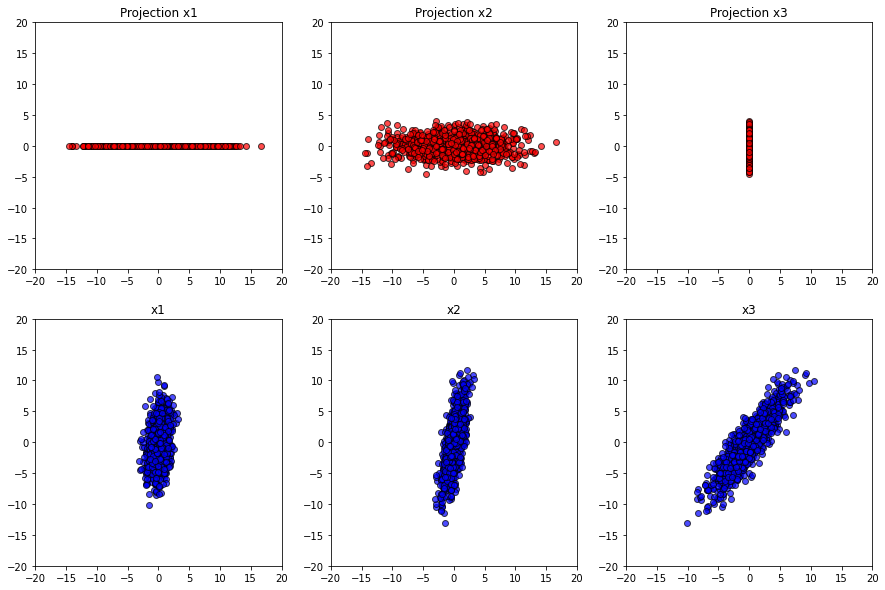

In [4]:
import matplotlib.pyplot as plt
#for the reduction
n_component = 3
# idx = np.argsort(l)[::-1] #reverse a list
# l = l[idx]
# V = V[idx]
# component = V[0:n_component]
# new_eigenvalues = l[0:n_component]
# print(component.shape, df.shape)

new_df = np.dot(V.T, df)

x1_new = new_df[0,:]
x2_new =  new_df[1,:]
x3_new =  new_df[2,:]

print('The red scatterplot are the projection, the blu the initial')
fig , ((ax1,ax2,ax3) , (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax1.scatter(x1_new,x2_new, c='red',alpha=0.7,  edgecolor='black')
ax1.set_xlim([-20,20])
ax1.set_ylim([-20,20])
ax1.set_title('Projection x1')

ax4.scatter(x1,x2, c='blue',alpha=0.7,  edgecolor='black')
ax4.set_xlim([-20,20])
ax4.set_ylim([-20,20])
ax4.set_title('x1')

ax2.scatter(x1_new, x3_new, c='red',alpha=0.7,  edgecolor='black')
ax2.set_xlim([-20,20])
ax2.set_ylim([-20,20])
ax2.set_title('Projection x2')

ax5.scatter(x1,x3, c='blue',alpha=0.7,  edgecolor='black')
ax5.set_xlim([-20,20])
ax5.set_ylim([-20,20])
ax5.set_title('x2')

ax3.scatter(x2_new, x3_new, c='red',alpha=0.7,  edgecolor='black')
ax3.set_xlim([-20,20])
ax3.set_ylim([-20,20])
ax3.set_title('Projection x3')

ax6.scatter(x2,x3, c='blue',alpha=0.7,  edgecolor='black')
ax6.set_xlim([-20,20])
ax6.set_ylim([-20,20])
ax6.set_title('x3')



2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [5]:
df = pd.DataFrame(data)
sd = 1/50
mean = 0
noise_list=[]
for i in range(10):
    noise_list.append(np.random.normal(mean,sd,N))

noise = pd.DataFrame(noise_list, index=['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10'])
df_noise = df.append(noise)

n_component = 3
sigma_noise = np.cov(df_noise)
ln, Vn = la.eig(sigma_noise)

print('Eigenvalues of the covariant matrix of the noise dat frame are:\n',ln)

idx_n = np.argsort(ln)[::-1] #reverse a list
ln = ln[idx_n]
Vn = Vn[idx_n]

component_n = Vn[0:n_component]
new_eigenvalues_n = ln[0:n_component]

new_df_noise = np.dot(component_n, df_noise)

Lamba = np.diag(ln)
print('First 2-componenents variability',(Lamba[0,0]+Lamba[1,1])/Lamba.trace()*100)
"""The noise variability is really less meaning"""
# x1n = new_df_noise[0,:]
# x2n = new_df_noise[1,:]
# x3n = new_df_noise[2,:]

# fig, ax1= plt.subplots()
# ax1.scatter(x1n, x2n)
# ax1.scatter(x1,x2)

# fig, ax1= plt.subplots()
# ax1.scatter(x1n, x3n)
# ax1.scatter(x1,x3)

# fig, ax1= plt.subplots()
# ax1.scatter(x2n, x3n)
# ax1.scatter(x2,x3)


Eigenvalues of the covariant matrix of the noise dat frame are:
 [ 2.60549704e+01+0.j  1.94431103e+00+0.j -2.96453095e-16+0.j
  4.78317675e-04+0.j  3.33550327e-04+0.j  4.50302839e-04+0.j
  4.39659437e-04+0.j  3.51183150e-04+0.j  3.60623522e-04+0.j
  3.79251903e-04+0.j  4.13425784e-04+0.j  3.95612105e-04+0.j
  4.01838593e-04+0.j]
First 2-componenents variability (99.9857025156165+0j)


'The noise variability is really less meaning'

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


Text(0.5, 0, 'y (noise) ')

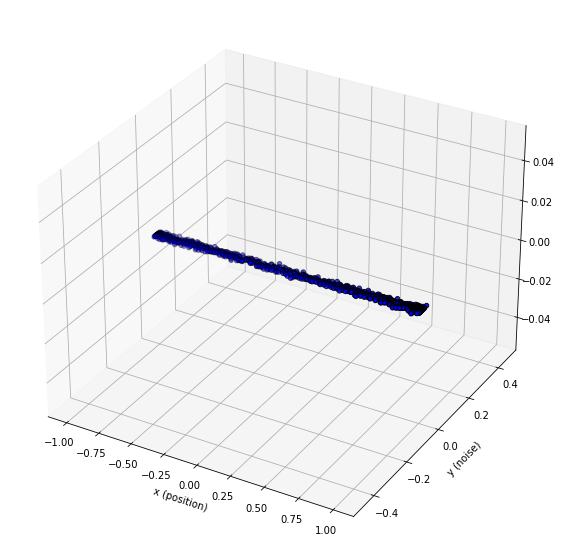

In [6]:
A = 1
N=1000

t=np.linspace(0,20,N) #istanti tempo che va da 0 a 5 secondi (1000 istanti) ==> 1000 fotografie==> 1000 cameras
x_spring = A*np.cos(t)
y_noise = np.random.normal(0,0.01,N)
z = np.zeros(N)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x_spring, y_noise, z, color='blue' , edgecolor='black')
ax.set_ylim([-0.5,0.5])
ax.set_xlabel('x (position)')
ax.set_ylabel('y (noise) ')


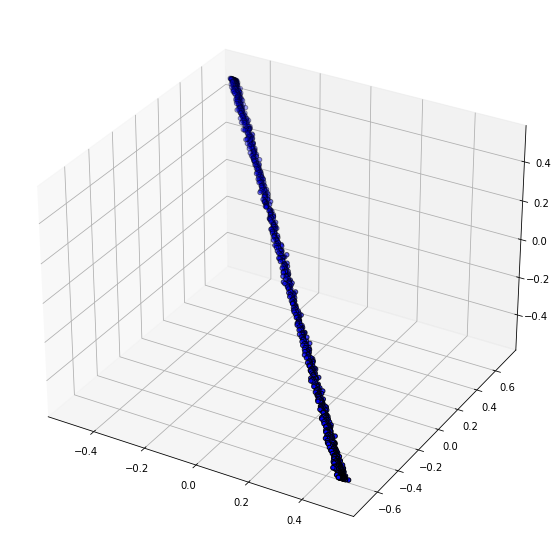

In [7]:
# camera with theta=pi/4, phi=pi/4
from numpy import pi,sin,cos
x=cos(pi/4)
y=sin(pi/4)
rot_y=([x,0,y],[0,1,0],[-y,0,x])
rot_z=([x,y,0],[-y,x,0],[0,0,1])
rot=np.dot(rot_y,rot_z) #rotation matrix for theta=pi/4, phi=pi/4

rotated = np.dot(rot,([x_spring,y_noise,z]))
x,y,z = rotated[0],rotated[1],rotated[2]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, color='blue' , edgecolor='black')

# def rot(theta,phi):
#     rot_y=([])
#     rot_z=([])
#     return 

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [8]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 


"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [9]:
# file_name = "C:/Users/Pietro/Documents/PHISICS OF DATA I/Computational Physics/LaboratoryOfComputationalPhysics_Y4/magic04.data"
# data = pd.read_csv(file_name, header=None)
# data = data.iloc[: , :-1]
# data.shape #abbiamo 3 features e 1000 samples
# pca2 = PCA(2)
# pca2.fit(data)
# data_proj = pca2.trasform(data)
# print(data_proj.shape)
# print(data.shape)

(19020, 10)

In [10]:
# class PCA:

#     def __init__(self,n_components):
#         self.n_components = n_components
#         self.components = None
#         self.mean = None
    
#     def fit(self, X):
#         #mean
#         self.mean = np.mean(X,axis=0)
#         #covariance
#         #row = 1 sample, columns=feature
#         cov = np.cov(X)
#         #eigen
#         l, V = la.eig(cov)
#         #v[:,i]
#         #sort
#         V = V
#         indx = np.argsort(l)[::-1]
#         l = l[indx]
#         V = V[indx]
#         #store first
#         self.components = V[0:self.n_components]

#     def trasform(self, X):
#         #projection of the sample
#         X = X - self.mean
#         return np.dot(X, self.components.T)
        
# #abbiamo 3 features e 1000 samples
# pca = PCA(2)
# pca.fit(df)
# df_proj = pca.trasform(df)

# print(df_proj.shape)
# print(df.shape)
# import matplotlib.pyplot as plt

# x1 = df_proj[:, 0]
# x2 = df_proj[:, 1]

# colors = np.random.rand(N)
# plt.scatter(x1, x2, c= colors , edgecolors='none', alpha=0.8)
# plt.xlabel('component 1')
# plt.ylabel('component 2')
# plt.show()
